In [1]:
#Color printing
from termcolor import colored

from datetime import datetime
import numpy as np

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf

#Plotting libraries
#import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


#Hide GPU
tf.config.set_visible_devices([], 'GPU')

In [2]:
# lets start by preprocessing the input text. apart from the usual stuff like all low letters, 
# here are 2 things worth noting. First is the dynamicly loaded text that i had to implement as I dont have acces to gpu and therefore my script crashed after
# running out of RAM. Second part is the <start> and <end> tokens that i used to make the script capable of ending the sentence. After reading some papers I found out thats the way models
# like GPT-2.0 knew how to end the sentence.

def preprocess_text(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, r'[^a-z\s]', '')
    words = tf.strings.split(text)
    words = tf.concat([['<start>'], words, ['<end>']], axis=0)
    return words


def text_generator(path):
    with open(path, 'r') as file:
        for line in file:
            words = preprocess_text(line)
            for i in range(len(words) - 1):
                yield words[i].numpy().decode('utf-8'), words[i+1].numpy().decode('utf-8')
                

In [3]:
# as during classes, we make a dataset using generator
PATH_INPUT = 'PATH_TO_DATASET'

dataset = tf.data.Dataset.from_generator(
    lambda: text_generator(PATH_INPUT),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)

In [6]:
# We create the vocabulary. This step takes a long time and thats why i aslo provided a ready saved set
words = set()
for word1, word2 in text_generator(PATH_INPUT):
    words.add(word1)
    words.add(word2)

KeyboardInterrupt: 

In [5]:
# here we load the set.

with open('.../words_set.pickle', 'rb') as f:
    words = pickle.load(f)

vocabulary = sorted(list(words))

#simple encoder decoder
word_to_index = {word: index for index, word in enumerate(vocabulary)}
index_to_word = {index: word for word, index in word_to_index.items()}

In [6]:
# Create a lookup table for words to indices
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(vocabulary),
        values=tf.constant(list(range(len(vocabulary))), dtype=tf.int32)
    ),
    default_value=tf.constant(-1),
    name="table"
)

def words_to_indices(word1, word2):
    return table.lookup(word1), table.lookup(word2)

# Map words in the dataset to their indices
dataset = dataset.map(words_to_indices)
dataset = dataset.map(lambda x, y: (tf.expand_dims(x, -1), y))
dataset = dataset.shuffle(buffer_size=10000)

In [7]:
# We make trainign and validation sets
val_size = int(len(list(dataset)) * 0.2)


val_dataset = dataset.take(val_size).batch(64, drop_remainder=True)
train_dataset = dataset.skip(val_size).batch(64, drop_remainder=True)

In [19]:
# I dont have a strong computer and thats why i save almost everything. the set() creeation took me 15 minutes which is long, but understandable for a dataset this big

tf.data.experimental.save(train_dataset, 'train_dataset')
tf.data.experimental.save(val_dataset, 'val_dataset')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [12]:
# quick function for loading the vlaidation and training datasets
settings = (tf.TensorSpec(shape=(64, 1), dtype=tf.int32), tf.TensorSpec(shape=(64,), dtype=tf.int32))

train_dataset = tf.data.Dataset.load('train_dataset', element_spec = settings)
val_dataset = tf.data.Dataset.load('val_dataset', element_spec = settings)

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


: 

: 

In [9]:

# using keras.model we create our bigram LM. I added the lstm and dropout layers to make the model model better. before adding them, the model didnt work at all.
class BigramModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim=256):
        super(BigramModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.lstm = tf.keras.layers.LSTM(256, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm(x) 
        x = self.dense(x)
        return x

In [10]:
# classic stuff. define the model, compile it, set early stopping and learning rate
model = BigramModel(len(vocabulary))
model.build(input_shape=(None, 1))
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy', 'val_loss'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)



Model: "bigram_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  3289344   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 lstm (LSTM)                 multiple                  525312    
                                                                 
 dense (Dense)               multiple                  3302193   
                                                                 
Total params: 7116849 (27.15 MB)
Trainable params: 7116849 (27.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



In [15]:
# Train the model with validation

#history = model.fit(train_dataset, epochs=4, validation_data=val_dataset, callbacks=[early_stopping, lr_schedule])

# or loading the model and history.
model = tf.keras.models.load_model('Bigram_model')

with open('history.pickle', 'rb') as f:
    history = pickle.load(f)


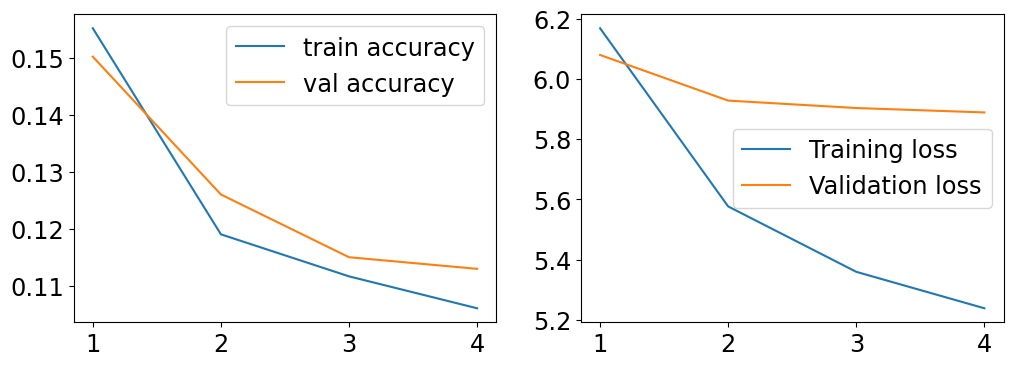

In [17]:
# Here we plot the mterics. We know that the model doesnt do well as even tho the loss is diminishing the accuracy also does so. I couldnt fix this error.
def plot_history(history):
    epochs = range(1, len(history['val_accuracy']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='train accuracy')
    plt.plot(epochs, history['val_accuracy'], label='val accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training loss')
    plt.plot(epochs, history['val_loss'], label='Validation loss')

    plt.legend()

    plt.show()

plot_history(history)

In [27]:
def generate_text_2(model, start_word, max_words=50):
    word = start_word
    generated_words = [word]
    
    for _ in range(max_words):
        input_index = np.array([[word_to_index[word]]])
        prediction = model(input_index)
        predicted_index = np.argmax(prediction, axis=-1)[0][0]
        word = index_to_word[predicted_index]
        
        if word == '<end>':
            break
        
        generated_words.append(word)
    
    return generated_words

print(generate_text_2(model, start_word="achieve", max_words=20))

['achieve', 'the', 'world']


In [28]:
# quick test to check how moidel is doing by random word pulling. The bad thing is that, the model doesnt create a coherent sentences of any kind but the good this is that it knows when to stop. 
# Our implementation of <end> token made it possible for the model to end the sentence.
for _ in range(50):
    index = np.random.randint(len(index_to_word))
    print(f"For word: {index_to_word[index]} the response is:")
    print(generate_text_2(model,start_word=index_to_word[index],max_words=5))


For word: banishment the response is:
['banishment']
For word: mingle the response is:
['mingle']
For word: mountebank the response is:
['mountebank']
For word: paws the response is:
['paws']
For word: ive the response is:
['ive']
For word: joindstool the response is:
['joindstool']
For word: sustain the response is:
['sustain']
For word: cursing the response is:
['cursing']
For word: severing the response is:
['severing']
For word: doubtthat the response is:
['doubtthat']
For word: grandmother the response is:
['grandmother']
For word: talks the response is:
['talks']
For word: senseless the response is:
['senseless']
For word: mart the response is:
['mart']
For word: sedition the response is:
['sedition']
For word: suspected the response is:
['suspected']
For word: jaws the response is:
['jaws']
For word: camel the response is:
['camel']
For word: poise the response is:
['poise']
For word: gentlemanlike the response is:
['gentlemanlike']
For word: monachum the response is:
['monachum